Primeira versão dos dados

In [41]:
import pandas as pd
import numpy as np
import scipy
import pmdarima as pm
import statsmodels.api as sm
import os
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime
import seaborn as sns
import warnings
import arch
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [60]:
# Lendo a base:
df_imp = pd.read_excel(r'C:\Users\adelia.lima\Desktop\Projetos\Previsão FPE\Impostos - ICMS - ITCD - IPVA - IRRF - 1999 - 2025 (1).xlsx', sheet_name='dados_1999_2025')

df_imp['data'] = pd.Series(pd.date_range(start = '1999-01-01', end = '2025-04-30', freq = 'MS'))
df_imp.index = df_imp['data']
df_imp = df_imp.drop(columns =  ['ANO', 'MES', 'data'])
df_imp = df_imp.loc['1999-01-01':'2025-04-30']
df_imp


,ICMS,IPVA,ITCD,IRRF,FPE
data,,,,,
1999-01-01,4.035843e+07,6.589567e+05,21163.97,3.293230e+03,NaN
1999-02-01,3.894808e+07,1.032605e+06,13089.30,8.150040e+03,NaN
1999-03-01,3.194334e+07,2.489991e+06,26279.08,0.000000e+00,NaN
1999-04-01,3.415198e+07,1.851256e+06,42705.30,0.000000e+00,NaN
1999-05-01,3.282836e+07,1.905139e+06,27892.99,0.000000e+00,NaN
...,...,...,...,...,...
2024-12-01,7.482734e+08,2.439870e+07,8035241.70,8.646344e+07,824096772.0
2025-01-01,7.365750e+08,1.071882e+08,9788218.42,8.744457e+07,721378548.0
2025-02-01,8.281093e+08,5.073087e+07,7272273.46,1.966352e+08,987992060.0


In [61]:
df_imp.dtypes

ICMS    float64
IPVA    float64
ITCD    float64
IRRF    float64
FPE     float64
dtype: object

In [62]:
df_fpe = pd.DataFrame(df_imp['FPE'].loc['2007-01-01':'2025-04-30'])

df_fpe

,FPE
data,
2007-01-01,1.328773e+08
2007-02-01,1.353935e+08
2007-03-01,1.123803e+08
2007-04-01,1.457194e+08
2007-05-01,1.439643e+08
...,...
2024-12-01,8.240968e+08
2025-01-01,7.213785e+08
2025-02-01,9.879921e+08


In [63]:
# Importando as dependencias das bibliotecas:

from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot
from scipy import stats
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
%matplotlib inline
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast

FPE - 2007-01-01 a 2025-04-30

80% - 2007-01-01 a 2024-04-30
20% - 2024-05-01 a 2025-04-30 (12 meses mais recentes a frente da serie para serem previstos como teste)

In [69]:
mod_hw_am = ExponentialSmoothing(df_fpe, seasonal_periods=12, trend='add', seasonal='mul').fit(optimized=1)
mod_hw_aa = ExponentialSmoothing(df_fpe, seasonal_periods=12, trend='add', seasonal='add').fit(optimized=1)
mod_hw_ma = ExponentialSmoothing(df_fpe, seasonal_periods=12, trend='mul', seasonal='add').fit(optimized=1)
mod_hw_mm = ExponentialSmoothing(df_fpe, seasonal_periods=12, trend='mul', seasonal='mul').fit(optimized=1)

# Iniciando a previsão  o componente aditivo-multiplicativo: (20% restantes da serie)

pred_hw_am = mod_hw_am.forecast(12)
predval_hw_am = pd.concat([df_fpe, pred_hw_am])
predval_hw_am = pd.DataFrame(predval_hw_am)
predval_hw_am = predval_hw_am.rename(columns={0: 'Previsto - HWam'})

# Previsao com  o componente aditivo-aditivo: (20% restantes da serie)
pred_hw_aa = mod_hw_aa.forecast(12)
predval_hw_aa = pd.concat([df_fpe, pred_hw_aa])
predval_hw_aa = pd.DataFrame(predval_hw_aa)
predval_hw_aa = predval_hw_aa.rename(columns={0: 'Previsto - HWaa'})

#Previsão com  o componente multiplicativo-aditivo: (20% restantes da serie)
pred_hw_ma = mod_hw_ma.forecast(12)
predval_hw_ma = pd.concat([df_fpe, pred_hw_ma])
predval_hw_ma = pd.DataFrame(predval_hw_ma)
predval_hw_ma = predval_hw_ma.rename(columns={0: 'Previsto - HWma'})

# Previsão com  o componente multiplicativo-multiplicativo: (20% restantes da serie)

pred_hw_mm = mod_hw_mm.forecast(12)
predval_hw_mm = pd.concat([df_fpe, pred_hw_mm])
predval_hw_mm = pd.DataFrame(predval_hw_mm)
predval_hw_mm = predval_hw_mm.rename(columns={0: 'Previsto - HWmm'})

# Criando dataframe novo com as previsões realizadas: 

df_fpe_prev = pd.DataFrame(columns=['VALOR PREVISTO - AM','VALOR PREVISTO - AA','VALOR PREVISTO - MA','VALOR PREVISTO - MM'])
df_fpe_prev['VALOR PREVISTO - AM'] = pred_hw_am
df_fpe_prev['VALOR PREVISTO - AA'] = pred_hw_aa
df_fpe_prev['VALOR PREVISTO - MA'] = pred_hw_ma
df_fpe_prev['VALOR PREVISTO - MM'] = pred_hw_mm

# Adicionando no dataframe novo com as previsões o intervalo de confiança 95%: Com P critico de 1.96

# componente aditivo-multiplicativo:

df_fpe_prev['Intervalo Inferior - AM'] = pred_hw_am - 1.96 * pred_hw_am.sem()
df_fpe_prev['Intervalo Superior - AM'] = pred_hw_am + 1.96 * pred_hw_am.sem()

#componente aditivo-aditivo:
df_fpe_prev['Intervalo Inferior - AA'] = pred_hw_aa - 1.96 * pred_hw_aa.sem()
df_fpe_prev['Intervalo Superior - AA'] = pred_hw_aa + 1.96 * pred_hw_aa.sem()

# componente multiplicativo-aditivo:

df_fpe_prev['Intervalo Inferior - MA'] = pred_hw_ma - 1.96 * pred_hw_ma.sem()
df_fpe_prev['Intervalo Superior - MA'] = pred_hw_ma + 1.96 * pred_hw_ma.sem()

# componente multiplicativo-multiplicativo:

df_fpe_prev['Intervalo Inferior - MM'] = pred_hw_mm - 1.96 * pred_hw_mm.sem()
df_fpe_prev['Intervalo Superior - MM'] = pred_hw_mm + 1.96 * pred_hw_mm.sem()


In [70]:
# Realizando o teste MAPE:

# componente Aditivo-Multiplicativo:
teste_mape_am = pd.DataFrame(df_imp['FPE'].loc['2024-05-01':'2025-04-30'])
print('MAPE - AM:', round(MAPE(teste_mape_am, df_fpe_prev['VALOR PREVISTO - AM'])*100,2),"%")
print('MSE - AM:', round(MSE(teste_mape_am, df_fpe_prev['VALOR PREVISTO - AM']),2))
print("RMSE do modelo: %.3f" % np.sqrt(MSE(teste_mape_am, df_fpe_prev['VALOR PREVISTO - AM'])))
print(' ')

# componente aditivo-aditivo:

teste_mape_aa = pd.DataFrame(df_imp['FPE'].loc['2024-05-01':'2025-04-30'])
print('MAPE - AA:', round(MAPE(teste_mape_am, df_fpe_prev['VALOR PREVISTO - AA'])*100,2),"%")
print('MSE - AA:', round(MSE(teste_mape_am, df_fpe_prev['VALOR PREVISTO - AA']),2))
print("RMSE do modelo: %.3f" % np.sqrt(MSE(teste_mape_aa, df_fpe_prev['VALOR PREVISTO - AA'])))
print(' ')
# componente multiplicativo-aditivo:

teste_mape_ma = pd.DataFrame(df_imp['FPE'].loc['2024-05-01':'2025-04-30'])
print('MAPE - MA:', round(MAPE(teste_mape_ma, df_fpe_prev['VALOR PREVISTO - MA'])*100,2),"%")
print('MSE - MA:', round(MSE(teste_mape_ma, df_fpe_prev['VALOR PREVISTO - MA']),2))
print("RMSE do modelo: %.3f" % np.sqrt(MSE(teste_mape_ma, df_fpe_prev['VALOR PREVISTO - MA'])))
print(' ')

# componente multiplicativo-multiplicativo:

teste_mape_mm = pd.DataFrame(df_imp['FPE'].loc['2024-05-01':'2025-04-30'])
print('MAPE - MM:', round(MAPE(teste_mape_mm, df_fpe_prev['VALOR PREVISTO - MM'])*100,2),"%")
print('MSE - MM:', round(MSE(teste_mape_mm, df_fpe_prev['VALOR PREVISTO - MM']),2))
print("RMSE do modelo: %.3f" % np.sqrt(MSE(teste_mape_mm, df_fpe_prev['VALOR PREVISTO - MM'])))
print(' ')

MAPE - AM: 4.43 %
MSE - AM: 1505128946915454.0
RMSE do modelo: 38795991.377
 
MAPE - AA: 5.32 %
MSE - AA: 1355532514822059.0
RMSE do modelo: 36817557.154
 
MAPE - MA: 10.19 %
MSE - MA: 5120273042936701.0
RMSE do modelo: 71556083.200
 
MAPE - MM: 9.13 %
MSE - MM: 5527641112386139.0
RMSE do modelo: 74348107.658
 


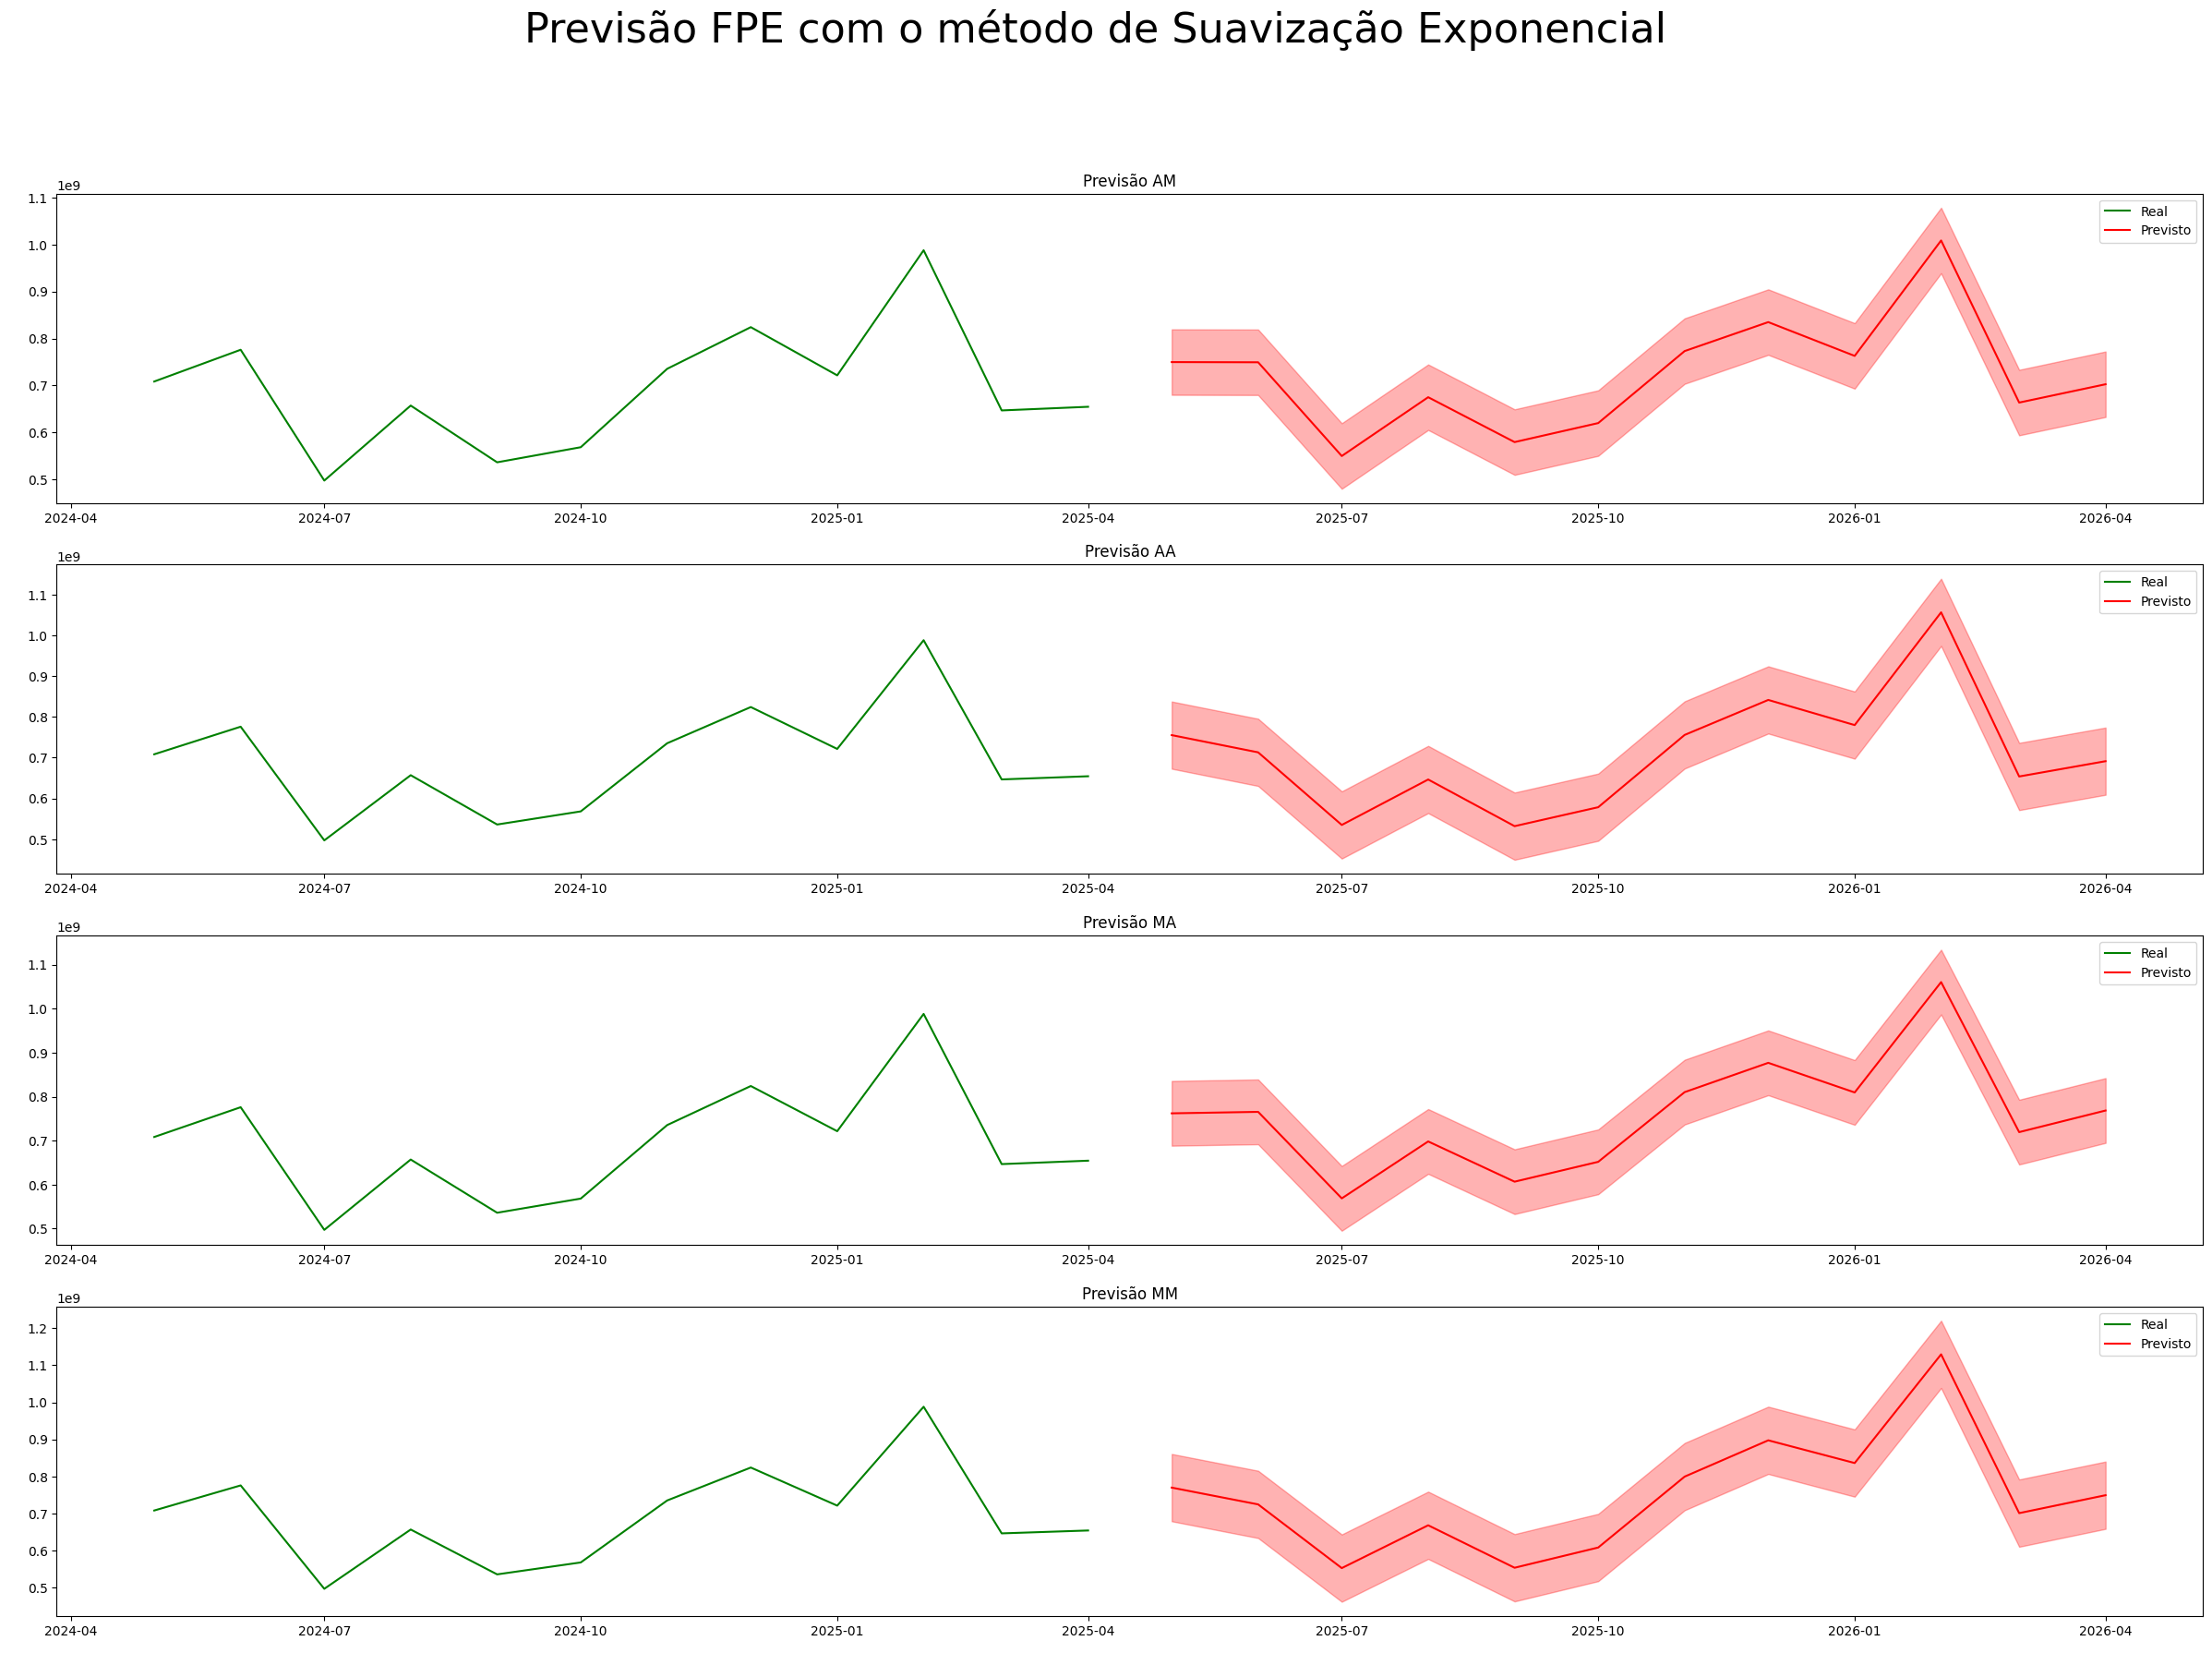

In [72]:
# Codigo para plotar os graficos de uma vez:

fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows = 4, ncols = 1, figsize = (30 , 20))
fig.suptitle('Previsão FPE com o método de Suavização Exponencial', size = 32)
ax0.set_title('Previsão AM', size = 12)
ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax1.set_title('Previsão AA', size = 12)
ax1.set_xlabel(' ')
ax1.set_ylabel(' ')
ax2.set_title('Previsão MA', size = 12)
ax2.set_xlabel(' ')
ax2.set_ylabel(' ')
ax3.set_title('Previsão MM', size = 12)
ax3.set_xlabel(' ')
ax3.set_ylabel(' ')

# Grafico Aditivo-Aditivo:
sns.lineplot(x = df_imp.loc[df_imp.index >= '2024-05-01'].index,
             y = df_imp.loc[df_imp.index >= '2024-05-01'].FPE,
             color = 'green',
             label = 'Real',
             ax=ax0)
sns.lineplot(x = df_fpe_prev.index,
             y = df_fpe_prev['VALOR PREVISTO - AA'],
             color = 'red',
             label = 'Previsto',
             ax=ax0)
ax0.fill_between(df_fpe_prev.index,
                 df_fpe_prev['Intervalo Inferior - AA'],
                 df_fpe_prev['Intervalo Superior - AA'],
                 alpha = 0.3,
                 color = 'Red')

# Grafico Aditivo-Multiplicativo

sns.lineplot(x = df_imp.loc[df_imp.index >= '2024-05-01'].index,
             y = df_imp.loc[df_imp.index >= '2024-05-01'].FPE,
             color = 'green',
             label = 'Real',
             ax = ax1)
sns.lineplot(x = df_fpe_prev.index,
             y = df_fpe_prev['VALOR PREVISTO - AM'],
             color = 'red',
             label = 'Previsto',
             ax = ax1)
ax1.fill_between(df_fpe_prev.index,
                 df_fpe_prev['Intervalo Inferior - AM'],
                 df_fpe_prev['Intervalo Superior - AM'],
                 alpha = 0.3,
                 color = 'Red')

# Grafico Multiplicativo-Aditivo:

sns.lineplot(x = df_imp.loc[df_imp.index >= '2024-05-01'].index,
             y = df_imp.loc[df_imp.index >= '2024-05-01'].FPE,
             color = 'green',
             label = 'Real',
             ax = ax2)
sns.lineplot(x = df_fpe_prev.index,
             y = df_fpe_prev['VALOR PREVISTO - MA'],
             color = 'red',
             label = 'Previsto',
             ax = ax2)
ax2.fill_between(df_fpe_prev.index,
                 df_fpe_prev['Intervalo Inferior - MA'],
                 df_fpe_prev['Intervalo Superior - MA'],
                 alpha = 0.3,
                 color = 'Red')

# Grafico Multiplicativo-Multiplicativo:

sns.lineplot(x = df_imp.loc[df_imp.index >= '2024-05-01'].index,
             y = df_imp.loc[df_imp.index >= '2024-05-01'].FPE,
             color = 'green',
             label = 'Real',
             ax = ax3)
sns.lineplot(x = df_fpe_prev.index,
             y = df_fpe_prev['VALOR PREVISTO - MM'],
             color = 'red',
             label = 'Previsto',
             ax = ax3)
ax3.fill_between(df_fpe_prev.index,
                 df_fpe_prev['Intervalo Inferior - MM'],
                 df_fpe_prev['Intervalo Superior - MM'],
                 alpha = 0.3,
                 color = 'Red')